Minimal example of RelaxedBernoulliStraightThrough used in 1D Gaussian Mixture model, with custom guide based on AutoHierarchicalNormalMessenger.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoGuideList, AutoHierarchicalNormalMessenger
from pyro.infer.autoguide.utils import deep_getattr, deep_setattr
from pyro.nn.module import PyroParam
from torch.distributions import biject_to, constraints
from pyro.infer import SVI, Trace_ELBO, infer_discrete
from pyro.infer import Predictive
from pyro.poutine import block
from tqdm.auto import tqdm

Add mean to RelaxedBernoulliStraightThrough to make it useable with Messenger guides:

In [2]:
from pyro.distributions import RelaxedBernoulliStraightThrough
RelaxedBernoulliStraightThrough.mean = property(lambda self: self.probs)

Produce some data from two Normal distributions with different means:

In [3]:
def generate_data(n_components = 2, n_observations = 100, ps = 0.9):
    
    mus = torch.tensor((4., 4.))
    b = pyro.sample('b', dist.Bernoulli(probs = ps).expand([n_observations]).to_event(1))
                             
    mean = mus[0] + mus[1]*b
    
    data = pyro.sample("data_target", dist.Normal(loc = mean, scale = 1.))
    
    return data, b

Samples are discrete during sampling:

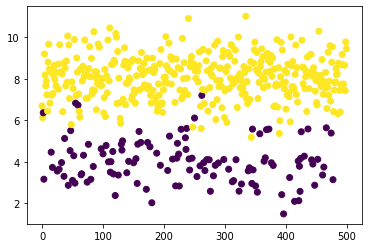

In [4]:
n_components = 2
n_observations = 500
ps = 0.75
data, b = generate_data(n_components, n_observations, ps)
plt.scatter(range(len(data)), data, c = b)

Our model using the Bernoulli distribution to assign observations to components:

In [5]:
def model(data, n_components, n_observations, i):
    
    ps = pyro.sample('ps', dist.Dirichlet(torch.ones(n_components) / 10.))
    mus = pyro.sample('mus', dist.Gamma(12, 2).expand([n_components]).to_event(1))
    b = pyro.sample('b', dist.Bernoulli(probs = ps[0]).expand([n_observations]).to_event(1))                    
    
    mean = mus[0] + mus[1]*b
    
    pyro.sample("data_target", dist.Normal(loc = mean, scale = torch.tensor(1.)).to_event(1), obs = data)

Define custom guide:

In [6]:
class MyGuideMessenger(AutoHierarchicalNormalMessenger):
    def get_posterior(self, name, prior):
        if isinstance(getattr(prior, "base_dist", None), dist.Bernoulli):
            transform = biject_to(dist.constraints.unit_interval)
            try:
                probs = deep_getattr(self.locs, name)
                if (self._hierarchical_sites is None) or (name in self._hierarchical_sites):
                    weight = deep_getattr(self.weights, name)
                    probs = transform(transform.inv(probs) + transform.inv(prior.mean) * weight)
            except AttributeError:
                # Initialize.
                with torch.no_grad():
                    # if site is hierarchical substract contribution of dependencies from init_loc
                    if (self._hierarchical_sites is None) or (name in self._hierarchical_sites):
                        init_probs = transform(torch.full_like(prior.mean, torch.zeros(())))
                        if self.weight_type == "scalar":
                            # weight is a single value parameter
                            init_weight = torch.full((), self._init_weight)
                        if self.weight_type == "element-wise":
                            # weight is element-wise
                            init_weight = torch.full_like(init_probs, self._init_weight)
                    else:
                        init_probs = prior.mean.clone().detach()

                deep_setattr(self, "locs." + name, PyroParam(
                    init_probs, 
                    constraint=dist.constraints.unit_interval,
                    event_dim=prior.event_dim, 
                ))
                probs = deep_getattr(self.locs, name)
                
                if (self._hierarchical_sites is None) or (name in self._hierarchical_sites):
                    if self.weight_type == "scalar":
                        # weight is a single value parameter
                        deep_setattr(
                            self,
                            "weights." + name,
                            PyroParam(init_weight, constraint=constraints.positive),
                        )
                    if self.weight_type == "element-wise":
                        # weight is element-wise
                        deep_setattr(
                            self,
                            "weights." + name,
                            PyroParam(
                                init_weight,
                                constraint=constraints.positive,
                                event_dim=prior.event_dim,
                            ),
                        )
                    weight = deep_getattr(self.weights, name)
                    
                    # If hierarchical_sites not specified all sites are assumed to be hierarchical
                    probs = transform(transform.inv(probs) + transform.inv(prior.mean) * weight)

            posterior = dist.RelaxedBernoulliStraightThrough(
                probs=probs, temperature=torch.tensor(1.0)
            ).to_event(prior.event_dim)
            return posterior
        else:    
            return super().get_posterior(name, prior)

guide = MyGuideMessenger(model, hierarchical_sites=['ps', 'mus', 'b'])

Training:

  0%|          | 0/10000 [00:00<?, ?it/s]

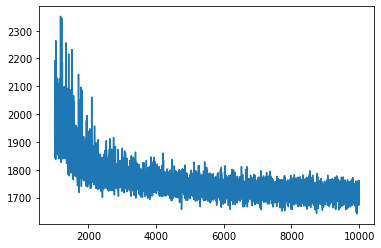

In [7]:
# Train model:
n_iterations = 10000
optim = pyro.optim.Adam({'lr': 0.001})
elbo = Trace_ELBO()
svi = SVI(model, guide, optim, loss=elbo)
elbos = []
for i in tqdm(range(n_iterations)):
    loss = svi.step(data, n_components, n_observations, i)
    elbos.append(loss)

posterior = Predictive(model, guide=guide, num_samples=1)(data, n_components, n_observations, i)

plt.plot(np.arange(1000, n_iterations, 1), elbos[1000:]);

Evaluate model:

In [8]:
print('Percentage correctly classified: ', np.array(torch.sum(b - posterior['b'] == 0)/len(b)))
b = torch.abs(b - 1)
print('Percentage correctly classified after switching categories: ', np.array(torch.sum(b - posterior['b'] == 0)/len(b)))
print('Percentage classified in category 1: ', np.array(torch.sum(b == 1)/len(b)))

Percentage correctly classified:  0.686
Percentage correctly classified after switching categories:  0.314
Percentage classified in category 1:  0.24


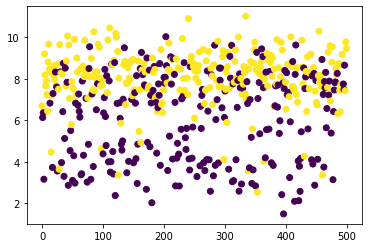

In [9]:
plt.scatter(range(len(data)), data, c = posterior['b'])

In [10]:
posterior['mus'], posterior['ps']

(tensor([[6.0002, 1.9992]]), tensor([[0.4653, 0.5347]]))